In [2]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt

In [3]:
# Load the data
df = pd.read_csv('model_data.csv', index_col = 0)

In [4]:
# Data for iterative imputing
df_iter_impute = df.copy()

#### Dealing with missing values

- Create 'missing' variables for columns with NaNs

In [5]:
# Create an indicator column for LowDoc_Encoded NAs
df_iter_impute['LowDoc_Encoded_missing'] = df_iter_impute['LowDoc_Encoded'].isna().astype(int)

# Create an indicator column for LowDoc_Encoded NAs
df_iter_impute['RevLineCr_Encoded_missing'] = df_iter_impute['RevLineCr_Encoded'].isna().astype(int)

# Create an indicator column for LowDoc_Encoded NAs
df_iter_impute['NewExist_Encode_missing'] = df_iter_impute['NewExist_Encode'].isna().astype(int)

# Create an indicator column for LowDoc_Encoded NAs
df_iter_impute['UrbanRural_Encoded'] = df_iter_impute['UrbanRural_Encoded'].isna().astype(int)

- Iteratively fill missing data points for columns with NaNs

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier

# Create a copy of the DataFrame 
df_target = df_iter_impute[['MIS_Status_Encoded', 'GrAppv', 'Term', 'FranchiseCode_Encoded', 'NAICS_class_code', 'RealEstate_Backed',
                       'LowDoc_Encoded', 'RevLineCr_Encoded', 'NewExist_Encode', 'UrbanRural_Encoded',]]

# Initialize the IterativeImputer
imputer = IterativeImputer(estimator=RandomForestClassifier(), random_state=42)

# Fit and transform the numeric columns
df_imputed = imputer.fit_transform(df_target)

df_imputed =pd.DataFrame(df_imputed, columns=df_target.columns)

NameError: name 'df_iter_impute' is not defined

In [6]:
# Create a list of columns used for the inputing
itered_columns = df_imputed.columns

# Fill NaNs with result from iterative inputs
df_iter_impute[itered_columns] = df_imputed[itered_columns]

# Verify no NaNs dataset
df_iter_impute.isna().sum()

MIS_Status_Encoded           0
NewExist_Encode              0
GrAppv                       0
CreateJob                    0
RetainedJob                  0
UrbanRural_Encoded           0
RevLineCr_Encoded            0
LowDoc_Encoded               0
NAICS                        0
NAICS_class_code             0
FranchiseCode_Encoded        0
Term                         0
TermDays                     0
NoEmp                        0
RealEstate_Backed            0
Region                       0
BankRegion                   0
LowDoc_Encoded_missing       0
RevLineCr_Encoded_missing    0
NewExist_Encode_missing      0
dtype: int64

#### One-Hot Encode categories

In [7]:
# One Hot-Encode the categorical variables
df_iter_impute = pd.get_dummies(df_iter_impute, columns=['Region', 'BankRegion']).fillna(0).astype('int64')

#### Check for Multicollinearity

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(df_iter_impute.drop(columns=['MIS_Status_Encoded']))

# Calculate the VIF for each feature
vif = pd.DataFrame()
vif["features"] = df_iter_impute.drop(columns=['MIS_Status_Encoded']).columns
vif["VIF Factor"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

vif['VIF Factor'] = round(vif['VIF Factor'], 2)

# Print the results
vif

,features,VIF Factor
0,NewExist_Encode,1.090000e+00
1,GrAppv,1.460000e+00
2,CreateJob,8.416000e+01
3,RetainedJob,8.412000e+01
4,UrbanRural_Encoded,1.770000e+00
5,RevLineCr_Encoded,1.640000e+00
6,LowDoc_Encoded,1.250000e+00
7,NAICS,1.340000e+00
8,NAICS_class_code,1.170000e+00
9,FranchiseCode_Encoded,1.060000e+00


In [9]:
# View the correlation between created and retained jobs.
df_iter_impute[['CreateJob', 'RetainedJob']].corr()

#  Similar VIF values observed

,CreateJob,RetainedJob
CreateJob,1.000000,0.993955
RetainedJob,0.993955,1.000000


In [10]:
# Drop one of the co-linear features
df_iter_impute.drop(columns=['TermDays', 'BankRegion_Southern', 'BankRegion_Western', 'BankRegion_Northern', 'BankRegion_Eastern', 'RetainedJob'], inplace=True)

In [11]:
# Re-run VIF for multicolineairty test

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(df_iter_impute.drop(columns=['MIS_Status_Encoded']))

# Calculate the VIF for each feature
vif = pd.DataFrame()
vif["features"] = df_iter_impute.drop(columns=['MIS_Status_Encoded']).columns
vif["VIF Factor"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

vif['VIF Factor'] = round(vif['VIF Factor'], 2)

# Confirm no mutlticollineairty in dataset (VIF > 5)
vif

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,features,VIF Factor
0,NewExist_Encode,1.08
1,GrAppv,1.46
2,CreateJob,1.00
3,UrbanRural_Encoded,1.77
4,RevLineCr_Encoded,1.61
5,LowDoc_Encoded,1.25
6,NAICS,1.34
7,NAICS_class_code,1.17
8,FranchiseCode_Encoded,1.06
9,Term,4.80


#### Outlier Detection (IQR)

In [12]:
def remove_outliers_iqr(df, column):
    """Removes outliers from a DataFrame column using the IQR method.

    Args:
        df: The Pandas DataFrame.
        column: The name of the column to remove outliers from.

    Returns:
        A new DataFrame with the outliers removed.
    """

    # Calculate quantiles and IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Calculate lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter data within bounds
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df_filtered

# Remove outliers from the DataFrame:
df_no_outliers_cj = remove_outliers_iqr(df_iter_impute, 'CreateJob')
df_no_outliers_tm = remove_outliers_iqr(df_no_outliers_cj, 'Term')
df_no_outliers_ne = remove_outliers_iqr(df_no_outliers_tm, 'NoEmp')
df_no_outliers_naic = remove_outliers_iqr(df_no_outliers_ne, 'NAICS')
df_no_outliers_naic_cd = remove_outliers_iqr(df_no_outliers_naic, 'NAICS_class_code')
df_no_outliers = remove_outliers_iqr(df_no_outliers_naic_cd, 'GrAppv')

# Print the shape of the DataFrame before and after outlier removal
print("Shape before outlier removal:", df_iter_impute.shape)
print("Shape after outlier removal:", df_no_outliers.shape)


Shape before outlier removal: (897167, 20)
Shape after outlier removal: (517052, 20)


In [13]:
df_iter_impute.shape[0] - df_no_outliers.shape[0]

380115

#### Validate Linearity Assumption

- Perform Box-Tidwell test to examine the relationship between continous predictor variables and their logit.

In [14]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# Create DataFrame
df_test = df_iter_impute[['MIS_Status_Encoded', 'GrAppv', 'CreateJob', 'NAICS', 'NAICS_class_code', 'Term', 'NoEmp']]

# Select predictor features
continuous_features = df_test[['GrAppv', 'CreateJob', 'NAICS', 'NAICS_class_code', 'Term', 'NoEmp']]

# Standardize the features
scaler = StandardScaler()
continuous_features = scaler.fit_transform(continuous_features)

# Convert the features to a DataFrame
continuous_features = pd.DataFrame(continuous_features, columns=['GrAppv', 'CreateJob', 'NAICS', 'NAICS_class_code', 'Term', 'NoEmp'])

# Create interaction terms with the log of the predictors
for col in continuous_features.columns:
    # Replace 0 with a small constant before taking the log to avoid -inf
    continuous_features[f'log_{col}'] = np.log(continuous_features[col].replace(0, 1e-9))
    continuous_features[f'interaction_{col}'] = continuous_features[col] * continuous_features[f'log_{col}']

# Replace any remaining -inf or NaN values with 0
continuous_features.replace([np.inf, -np.inf], np.nan, inplace=True)
continuous_features.fillna(0, inplace=True)

# Target feature
target_feature = df_test['MIS_Status_Encoded']

# Concatenate the features and target
df_test_final = pd.concat([continuous_features, target_feature], axis=1)

# Split the data into features and target
X = continuous_features
y = df_test['MIS_Status_Encoded']

X = sm.add_constant(X)
logit_model = sm.Logit(y, X)
result = logit_model.fit()

print(result.summary())

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/michaeladebayo/Documents/Simplon/brief_pr

Optimization terminated successfully.
         Current function value: 0.372610
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:     MIS_Status_Encoded   No. Observations:               897167
Model:                          Logit   Df Residuals:                   897148
Method:                           MLE   Df Model:                           18
Date:                Tue, 11 Feb 2025   Pseudo R-squ.:                  0.1981
Time:                        12:12:49   Log-Likelihood:            -3.3429e+05
converged:                       True   LL-Null:                   -4.1690e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            2.3548      0.008    303.928      0.000

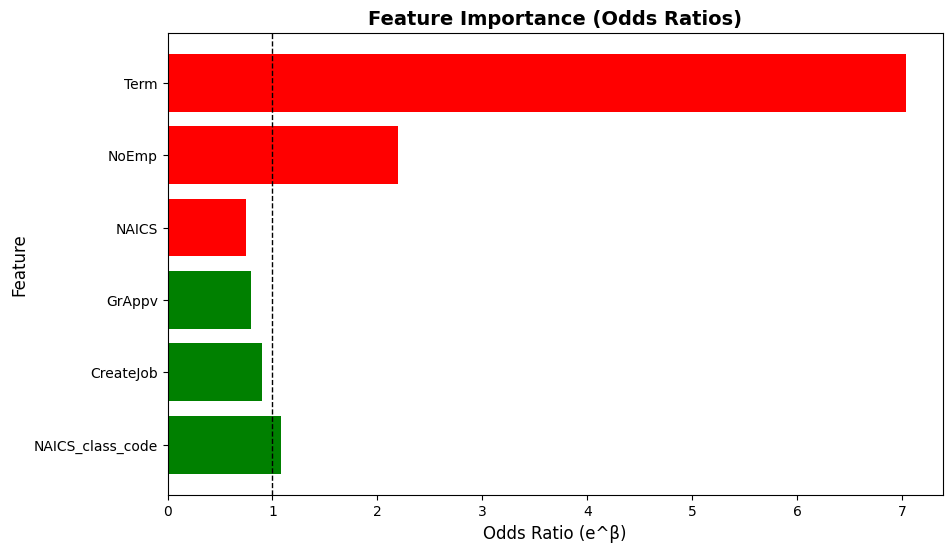

In [15]:
# Feature names and their coefficients
features = ["GrAppv", "CreateJob", "NAICS", "NAICS_class_code", "Term", "NoEmp"]
coefficients = [-0.2330, -0.1033, -0.2910, 0.0816, 1.9508, 0.7875]

# Compute odds ratios
odds_ratios = np.exp(coefficients)

# Sort features by importance
sorted_indices = np.argsort(np.abs(coefficients))[::-1]
sorted_features = [features[i] for i in sorted_indices]
sorted_odds_ratios = [odds_ratios[i] for i in sorted_indices]

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_odds_ratios, color=['red' if coef < 0 else 'green' for coef in coefficients])

# Labels and title
plt.xlabel("Odds Ratio (e^β)", fontsize = 12)
plt.ylabel("Feature", fontsize = 12)
plt.title("Feature Importance (Odds Ratios)", fontsize = 14, weight = 'bold')
plt.axvline(x=1, color='black', linestyle='--', linewidth=1)  # Reference line at OR=1

# Show plot
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

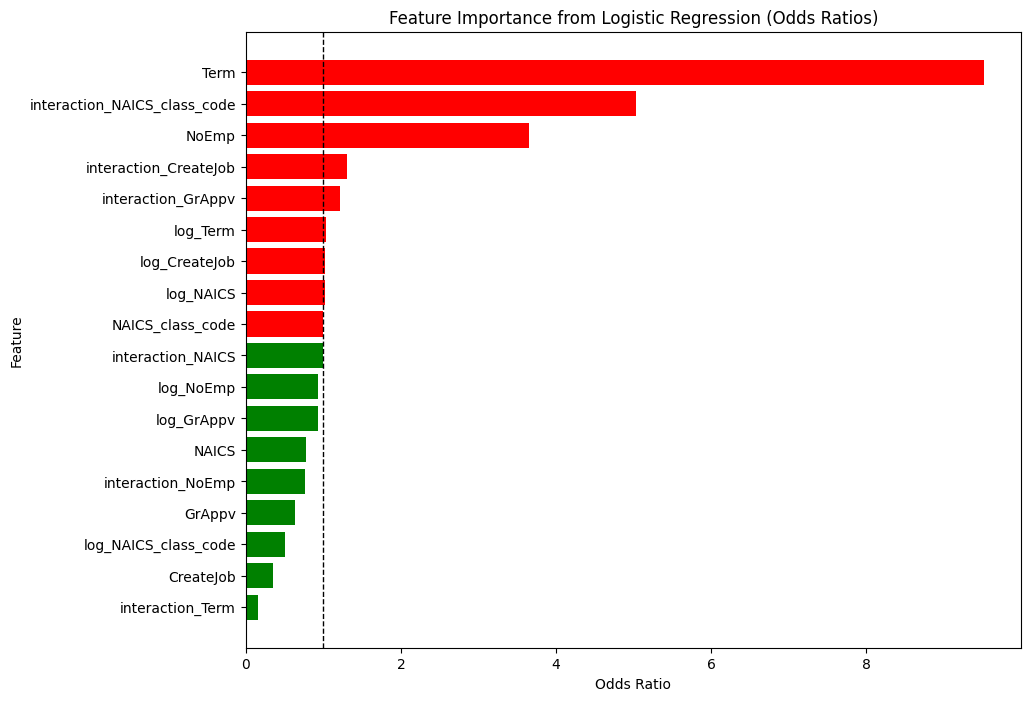

In [16]:
# Extract the coefficients from the logistic regression results
coefficients = result.params
feature_names = coefficients.index

# Calculate the odds ratios by exponentiating the coefficients
odds_ratios = np.exp(coefficients)

# Create a DataFrame with the feature names and their corresponding odds ratios
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Odds Ratio': odds_ratios,
    'Coefficient': coefficients
})

# Exclude the constant term
feature_importance = feature_importance[feature_importance['Feature'] != 'const']

# Sort the features by odds ratio
feature_importance = feature_importance.sort_values(by='Odds Ratio', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 8))
colors = ['red' if coef > 0 else 'green' for coef in feature_importance['Coefficient']]
plt.barh(feature_importance['Feature'], feature_importance['Odds Ratio'], color=colors)
plt.axvline(x=1, color='black', linestyle='--', linewidth=1)  # Reference line at OR=1
plt.xlabel('Odds Ratio')
plt.ylabel('Feature')
plt.title('Feature Importance from Logistic Regression (Odds Ratios)')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

#### Chi-Square Test (Categorial features vs Target)

- Evaluate if the relationship between categorical features and the target are significant.

In [17]:
from scipy.stats import chi2_contingency

def create_chi2(df, target, categorical_features):
    # Initialize a list to store results
    chi2_results = []

    # Perform the chi-square test for each categorical feature
    for feature in categorical_features:
        contingency_table = pd.crosstab(df[feature], df[target])  # Create contingency table
        chi2_stat, p, dof, expected = chi2_contingency(contingency_table)  # Chi-square test

        # Append results as a dictionary
        chi2_results.append({'Feature': feature, 'Chi2 Statistic': chi2_stat, 'p-value': p})

    # Convert list to DataFrame
    return pd.DataFrame(chi2_results)

# Define the categorical features
categorical_features = ['NewExist_Encode', 'NewExist_Encode_missing', 'UrbanRural_Encoded', 'LowDoc_Encoded', 
                        'LowDoc_Encoded_missing', 'RevLineCr_Encoded', 'RevLineCr_Encoded_missing', 'FranchiseCode_Encoded', 
                        'RealEstate_Backed', 'Region_Eastern', 'Region_Northern', 'Region_Southern', 'Region_Western']

# Call the function and store the results
chi2_results = create_chi2(df_iter_impute, 'MIS_Status_Encoded', categorical_features)

# Display the result
chi2_results

,Feature,Chi2 Statistic,p-value
0,NewExist_Encode,343.772194,9.624251e-77
1,NewExist_Encode_missing,95.346181,1.598406e-22
2,UrbanRural_Encoded,39928.912646,0.000000e+00
3,LowDoc_Encoded,6345.902721,0.000000e+00
4,LowDoc_Encoded_missing,317.026718,6.435107e-71
5,RevLineCr_Encoded,19470.155678,0.000000e+00
6,RevLineCr_Encoded_missing,447.566158,2.442250e-99
7,FranchiseCode_Encoded,212.460235,3.991415e-48
8,RealEstate_Backed,32116.698170,0.000000e+00
9,Region_Eastern,221.614688,4.019616e-50


### Exploring Different Logistic Models

#### Logistic Regression

In [18]:
# df_iter_impute.columns

In [19]:
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler, PolynomialFeatures
# from sklearn.model_selection import train_test_split, RandomizedSearchCV
# from sklearn.linear_model import LogisticRegression


# # Split the data into features and target
# X_logit = df_iter_impute.drop(columns=['MIS_Status_Encoded','NewExist_Encode_missing', 'LowDoc_Encoded_missing'])
# y_logit = df_iter_impute['MIS_Status_Encoded']

# # Split the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X_logit, y_logit, test_size=0.2, random_state=42, stratify=X_logit['FranchiseCode_Encoded'])

# # Define numerical and categorical features
# numerical_features = ['GrAppv', 'CreateJob', 'Term', 'NoEmp', 'NAICS', 'NAICS_class_code']
# categorical_features = ['NewExist_Encode', 'UrbanRural_Encoded', 'LowDoc_Encoded', 'RevLineCr_Encoded', 'RevLineCr_Encoded_missing', 'FranchiseCode_Encoded', 'RealEstate_Backed', 'Region_Eastern', 'Region_Northern', 'Region_Southern', 'Region_Western']

# # Define the preprocessor
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numerical_features),
#         ('cat', 'passthrough', categorical_features)
#     ])

# # Build Pipeline
# model_pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('poly', PolynomialFeatures(degree=2)),
#     ('logit', LogisticRegression(max_iter=15)),
# ])

# # Set RandomSearch parameters
# params = {"logit__penalty" : ['l2'],
#           "logit__solver" : ['lbfgs', 'liblinear', 'newton-cholesky'],
# }

# # Set RandomSearchCV parameters
# logit_random_search = RandomizedSearchCV(model_pipeline, param_distributions=params, cv=5, random_state= 42, error_score='raise')
# logit_random_search.fit(X_train, y_train)

# # Best parameterd and score
# print("Best Params", logit_random_search.best_estimator_)
# print("Best Score:", logit_random_search.best_score_)

# # Check the number of iterations
# best_model = logit_random_search.best_estimator_.named_steps['logit']
# print("Number of iterations:", best_model.n_iter_)

In [20]:
# # Import the accuracy metric
# from sklearn.metrics import accuracy_score, f1_score

# # Load model
# logistic_model = logit_random_search.best_estimator_

# # Make predictions
# y_pred = logistic_model.predict(X_test)

# # Calculate the accuracy
# accuracy = accuracy_score(y_test, y_pred)
# f1_score_score = f1_score(y_test, y_pred, average= 'macro')

# print(f'logistic regression accuracy: {accuracy}')
# print(f'logistic regression f1-score: {f1_score_score}')

In [21]:
# # Calculate ROC-AUC score
# from sklearn.model_selection import cross_val_score

# # Evaluate model using cross-validation
# logit_scores = cross_val_score(logit_random_search.best_estimator_, X_train, y_train, cv=5, scoring='roc_auc')
# print(f'ROC-AUC: {logit_scores.mean()}')

#### Random Forest Classifier

In [22]:
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler, PolynomialFeatures
# from sklearn.model_selection import train_test_split, RandomizedSearchCV
# from sklearn.ensemble import RandomForestClassifier

# # Split the data into features and target
# X_rf = df_iter_impute.drop(columns=['MIS_Status_Encoded'])
# y_rf = df_iter_impute['MIS_Status_Encoded']

# # Split the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42, stratify=X_rf['FranchiseCode_Encoded'])

# # Define numerical and categorical features
# numerical_features = ['GrAppv', 'CreateJob', 'Term', 'NoEmp', 'NAICS', 'NAICS_class_code']
# categorical_features = ['NewExist_Encode', 'UrbanRural_Encoded', 'LowDoc_Encoded', 'RevLineCr_Encoded', 
#                         'RevLineCr_Encoded_missing', 'FranchiseCode_Encoded', 'RealEstate_Backed', 'Region_Eastern',
#                         'Region_Northern', 'Region_Southern', 'Region_Western']

# # Define the preprocessor
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numerical_features),
#         ('cat', 'passthrough', categorical_features)
#     ])

# # Build Pipeline
# model_pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('poly', PolynomialFeatures(degree=2)),
#     ('random', RandomForestClassifier()),
# ])

# # Set RandomSearch parameters
# params = {"random__random_state": [None],
# }

# # Set RandomSearchCV parameters
# rf_random_search = RandomizedSearchCV(model_pipeline, param_distributions=params, cv=5, random_state= 42, error_score='raise')
# rf_random_search.fit(X_train, y_train)

# # Best parameterd and score
# print("Best Params", rf_random_search.best_estimator_)
# print("Best Score:", rf_random_search.best_score_)

In [23]:
# # Load model
# rf_model = rf_random_search.best_estimator_

# # Make predictions
# rf_y_pred = rf_model.predict(X_test)

# # Calculate the accuracy
# rf_accuracy = accuracy_score(y_test, rf_y_pred)
# rf_f1_score_score = f1_score(y_test, rf_y_pred)

# print(f'Random Forest accuracy: {rf_accuracy}')
# print(f'Random Forest f1-score: {rf_f1_score_score}')

In [24]:
# rf_scores = cross_val_score(rf_random_search.best_estimator_, X_train, y_train, cv=5, scoring='roc_auc')
# print(f'ROC-AUC: {rf_scores.mean()}')

#### XGBoost

In [25]:
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler, PolynomialFeatures
# from sklearn.model_selection import train_test_split, RandomizedSearchCV
# import xgboost as xgb

# # Split the data into features and target
# X_xgb = df_iter_impute.drop(columns=['MIS_Status_Encoded'])
# y_xgb = df_iter_impute['MIS_Status_Encoded']

# # Split the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X_xgb, y_xgb, test_size=0.2, random_state=42, stratify=X_xgb['FranchiseCode_Encoded'])

# # Define numerical and categorical features
# numerical_features = ['GrAppv', 'CreateJob', 'Term', 'NoEmp', 'NAICS', 'NAICS_class_code']
# categorical_features = ['NewExist_Encode', 'UrbanRural_Encoded', 'LowDoc_Encoded', 'RevLineCr_Encoded', 
#                         'RevLineCr_Encoded_missing', 'FranchiseCode_Encoded', 'RealEstate_Backed', 'Region_Eastern',
#                         'Region_Northern', 'Region_Southern', 'Region_Western']

# # Define the preprocessor
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numerical_features),
#         ('cat', 'passthrough', categorical_features)
#     ])

# # Build Pipeline
# model_pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('poly', PolynomialFeatures(degree=2)),
#     ('xgb', xgb.XGBRFClassifier()),
# ])

# # Set RandomSearch parameters
# params = {"xgb__booster" : ['gbtree']}

# # Set RandomSearchCV parameters
# xgb_random_search = RandomizedSearchCV(model_pipeline, param_distributions=params, cv=5, random_state= 42, error_score='raise')
# xgb_random_search.fit(X_train, y_train)

# # Best parameterd and score
# print("Best Params", xgb_random_search.best_estimator_)
# print("Best Score:", xgb_random_search.best_score_)

In [26]:
# # Load model
# xgb_model = xgb_random_search.best_estimator_

# # Make predictions
# xgb_y_pred = xgb_model.predict(X_test)

# # Calculate the accuracy
# xgb_accuracy = accuracy_score(y_test, xgb_y_pred)
# xgb_f1_score_score = f1_score(y_test, xgb_y_pred)

# print(f'XGB accuracy: {xgb_accuracy}')
# print(f'XGB f1-score: {xgb_f1_score_score}')

In [27]:
# xgb_scores = cross_val_score(xgb_random_search.best_estimator_, X_train, y_train, cv=5, scoring='roc_auc')
# print(f'ROC-AUC: {xgb_scores.mean()}')

In [28]:
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler, PolynomialFeatures
# from sklearn.model_selection import train_test_split, RandomizedSearchCV
# import xgboost as xgb

# # Split the data into features and target
# X_xgb = df_iter_impute.drop(columns=['MIS_Status_Encoded'])
# y_xgb = df_iter_impute['MIS_Status_Encoded']

# # Split the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X_xgb, y_xgb, test_size=0.2, random_state=42, stratify=y_xgb)

# # Define numerical and categorical features
# numerical_features = ['GrAppv', 'CreateJob', 'Term', 'NoEmp', 'NAICS', 'NAICS_class_code']
# categorical_features = ['NewExist_Encode', 'UrbanRural_Encoded', 'LowDoc_Encoded', 'RevLineCr_Encoded', 
#                         'RevLineCr_Encoded_missing', 'FranchiseCode_Encoded', 'RealEstate_Backed', 'Region_Eastern',
#                         'Region_Northern', 'Region_Southern', 'Region_Western']

# # Define the preprocessor
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numerical_features),
#         ('cat', 'passthrough', categorical_features)
#     ])

# # Build Pipeline
# model_pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('poly', PolynomialFeatures(degree=2)),
#     ('xgb', xgb.XGBRFClassifier()),
# ])

# # Set RandomSearch parameters
# params = {"xgb__booster" : ['gbtree']}

# # Set RandomSearchCV parameters
# xgb2_random_search = RandomizedSearchCV(model_pipeline, param_distributions=params, cv=5, random_state= 42, error_score='raise')
# xgb2_random_search.fit(X_train, y_train)

# # Best parameterd and score
# print("Best Params", xgb2_random_search.best_estimator_)
# print("Best Score:", xgb2_random_search.best_score_)

In [29]:
# # Load model
# xgb2_model = xgb2_random_search.best_estimator_

# # Make predictions
# xgb2_y_pred = xgb2_model.predict(X_test)

# # Calculate the accuracy
# xgb2_accuracy = accuracy_score(y_test, xgb2_y_pred)
# xgb2_f1_score_score = f1_score(y_test, xgb2_y_pred)

# print(f'XGB accuracy: {xgb2_accuracy}')
# print(f'XGB f1-score: {xgb2_f1_score_score}')

In [30]:
# df_dummies = df_cat[['Region', 'BankRegion']]
# df_cat_targeted = pd.get_dummies(df_dummies, columns=['Region', 'BankRegion']).astype('int64')

In [31]:
# df_cat = pd.concat([df_cat, df_cat_targeted], axis=1)

In [32]:
# df_cat.drop(['Region', 'BankRegion'], axis=1, inplace=True)

In [33]:
# df_cat.columns

In [34]:
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler, PolynomialFeatures
# from sklearn.model_selection import train_test_split, RandomizedSearchCV
# import xgboost as xgb
# from sklearn.impute import SimpleImputer

# # Split the data into features and target
# X_xgb_3 = df_cat.drop(columns=['MIS_Status_Encoded'])
# y_xgb_3 = df_cat['MIS_Status_Encoded']

# # Split the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X_xgb_3, y_xgb_3, test_size=0.2, random_state=42, stratify=y_xgb_3)

# # Define numerical and categorical features
# numerical_features = ['GrAppv', 'CreateJob', 'RetainedJob', 'Term', 'TermDays', 'NoEmp', 'NAICS', 'NAICS_class_code']
# categorical_features = ['NewExist_Encode', 'UrbanRural_Encoded', 'LowDoc_Encoded', 'RevLineCr_Encoded', 
#                         'FranchiseCode_Encoded', 'RealEstate_Backed', 'Region_Eastern',
#                         'Region_Northern', 'Region_Southern', 'Region_Western']

# # Define the preprocessor
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', Pipeline([
#             ('imputer', SimpleImputer(strategy='mean')),
#             ('scaler', StandardScaler())
#         ]), numerical_features),
#         ('cat', Pipeline([
#             ('imputer', SimpleImputer(strategy='most_frequent')),
#             ('encoder', 'passthrough')
#         ]), categorical_features)
#     ])

# # Build Pipeline
# model_pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('poly', PolynomialFeatures(degree=2)),
#     ('xgb', xgb.XGBRFClassifier()),
# ])

# # Set RandomSearch parameters
# params = {"xgb__booster" : ['gbtree']}

# # Set RandomSearchCV parameters
# xgb3_random_search = RandomizedSearchCV(model_pipeline, param_distributions=params, cv=5, random_state= 42, error_score='raise')
# xgb3_random_search.fit(X_train, y_train)

# # Best parameterd and score
# print("Best Params", xgb3_random_search.best_estimator_)
# print("Best Score:", xgb3_random_search.best_score_)

#### LightGBM

In [35]:
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler, PolynomialFeatures
# from sklearn.model_selection import train_test_split, RandomizedSearchCV
# import lightgbm as lgm
# from sklearn.impute import SimpleImputer

# # Split the data into features and target
# X_lgm = df_cat.drop(columns=['MIS_Status_Encoded'])
# y_lgm = df_cat['MIS_Status_Encoded']

# # Split the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X_lgm, y_lgm, test_size=0.2, random_state=42, stratify=y_lgm)

# # Define numerical and categorical features
# numerical_features = ['GrAppv', 'CreateJob', 'RetainedJob', 'Term', 'TermDays', 'NoEmp', 'NAICS', 'NAICS_class_code']
# categorical_features = ['NewExist_Encode', 'UrbanRural_Encoded', 'LowDoc_Encoded', 'RevLineCr_Encoded', 
#                         'FranchiseCode_Encoded', 'RealEstate_Backed', 'Region_Eastern',
#                         'Region_Northern', 'Region_Southern', 'Region_Western']

# # Define the preprocessor
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', Pipeline([
#             ('imputer', SimpleImputer(strategy='mean')),
#             ('scaler', StandardScaler())
#         ]), numerical_features),
#         ('cat', Pipeline([
#             ('imputer', SimpleImputer(strategy='most_frequent')),
#             ('encoder', 'passthrough')
#         ]), categorical_features)
#     ])

# # Build Pipeline
# model_pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('poly', PolynomialFeatures(degree=2)),
#     ('lgm', lgm.LGBMClassifier()),
# ])

# # Set RandomSearch parameters
# params = {"lgm__boosting_type" : ['gbdt']}

# # Set RandomSearchCV parameters
# lgm_random_search = RandomizedSearchCV(model_pipeline, param_distributions=params, cv=5, random_state= 42, error_score='raise')
# lgm_random_search.fit(X_train, y_train)

# # Best parameterd and score
# print("Best Params", lgm_random_search.best_estimator_)
# print("Best Score:", lgm_random_search.best_score_)

In [36]:
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler, PolynomialFeatures
# from sklearn.model_selection import train_test_split, RandomizedSearchCV
# import lightgbm as lgb

# # Split the data into features and target
# X_lgb = df_iter_impute.drop(columns=['MIS_Status_Encoded'])
# y_lgb = df_iter_impute['MIS_Status_Encoded']

# # Split the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X_lgb, y_lgb, test_size=0.2, random_state=42, stratify=y_lgb)

# # Define numerical and categorical features
# numerical_features = ['GrAppv', 'CreateJob', 'Term', 'NoEmp', 'NAICS', 'NAICS_class_code']
# categorical_features = ['NewExist_Encode', 'UrbanRural_Encoded', 'LowDoc_Encoded', 'RevLineCr_Encoded', 
#                         'RevLineCr_Encoded_missing', 'FranchiseCode_Encoded', 'RealEstate_Backed', 'Region_Eastern',
#                         'Region_Northern', 'Region_Southern', 'Region_Western']

# # Define the preprocessor
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numerical_features),
#         ('cat', 'passthrough', categorical_features)
#     ])

# # Build Pipeline
# model_pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('poly', PolynomialFeatures(degree=2)),
#     ('lgb', lgb.LGBMClassifier()),
# ])

# # Set RandomSearch parameters
# params = {"lgb__boosting_type" : ['gbdt']}

# # Set RandomSearchCV parameters
# lgb_random_search_2 = RandomizedSearchCV(model_pipeline, param_distributions=params, cv=5, random_state= 42, error_score='raise')
# lgb_random_search_2.fit(X_train, y_train)

# # Best parameterd and score
# print("Best Params", lgb_random_search_2.best_estimator_)
# print("Best Score:", lgb_random_search_2.best_score_)

In [37]:
# # Load model
# lgb2_model = lgb_random_search_2.best_estimator_

# # Make predictions
# lgb2_y_pred = lgb2_model.predict(X_test)

# # Calculate the accuracy
# lgb2_accuracy = accuracy_score(y_test, lgb2_y_pred)
# lgb2_f1_score_score = f1_score(y_test, lgb2_y_pred, average='binary')

# print(f'LGB accuracy: {lgb2_accuracy}')
# print(f'LGB f1-score: {lgb2_f1_score_score}')

In [38]:
# lgb2_scores = cross_val_score(lgb_random_search_2.best_estimator_, X_train, y_train, cv=5, scoring='roc_auc')
# print(f'ROC-AUC: {lgb2_scores.mean()}')

In [39]:
# df_iter_impute.to_csv('model_data_imputed.csv')

In [40]:
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler, PolynomialFeatures
# from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
# import lightgbm as lgb

# # Split the data into features and target
# X_lgb_rand = df_iter_impute.drop(columns=['MIS_Status_Encoded'])
# y_lgb_rand = df_iter_impute['MIS_Status_Encoded']

# # Split the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X_lgb_rand, y_lgb_rand, test_size=0.2, random_state=42, stratify=y_lgb_rand)

# # Define numerical and categorical features
# numerical_features = ['GrAppv', 'CreateJob', 'Term', 'NoEmp', 'NAICS', 'NAICS_class_code']
# categorical_features = ['NewExist_Encode', 'UrbanRural_Encoded', 'LowDoc_Encoded', 'RevLineCr_Encoded', 
#                         'RevLineCr_Encoded_missing', 'FranchiseCode_Encoded', 'RealEstate_Backed', 'Region_Eastern',
#                         'Region_Northern', 'Region_Southern', 'Region_Western']

# # Define the preprocessor
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numerical_features),
#         ('cat', 'passthrough', categorical_features)
#     ])

# # Build Pipeline
# model_pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('poly', PolynomialFeatures(degree=2)),
#     ('lgb', lgb.LGBMClassifier()),
# ])

# # Set RandomSearch parameters
# params = {
#     "lgb__boosting_type": ['gbdt', 'dart', 'rf'],
#     "lgb__learning_rate": [0.01, 0.05, 0.1],
#     "lgb__num_leaves": [31, 50],
#     "lgb__max_depth": [-1, 10],
#     "lgb__min_child_weight": [0.001, 0.01, 0.1],
#     "lgb__importance_type": ['split', 'gain'],
#     "lgb__objective": ['binary', 'cross_entropy'],
#     "lgb__class_weight": [None, 'balanced'],
#     "lgb__subsample": [0.8, 1.0],
#     "lgb__n_estimators": [100, 200],
#     "lgb__min_split_gain": [0.0, 0.1],
#     "lgb__bagging_freq": [1],  # Ensure bagging_freq is greater than 0
#     "lgb__bagging_fraction": [0.8],  # Ensure bagging_fraction is between 0.0 and 1.0
#     "lgb__feature_fraction": [0.8]  # Ensure feature_fraction is between 0.0 and 1.0
# }

# # Set RandomSearchCV parameters
# lgb_rand_search = RandomizedSearchCV(model_pipeline, param_distributions=params, cv=5, random_state= 40, error_score='raise')
# lgb_rand_search.fit(X_train, y_train)

# # Best parameterd and score
# print("Best Params", lgb_rand_search.best_estimator_)
# print("Best Score:", round(lgb_rand_search.best_score_, 2))

In [41]:
# from sklearn.metrics import accuracy_score, f1_score

# # Load model
# lgb_rand_model = lgb_rand_search.best_estimator_

# # Make predictions
# lgb_rand_y_pred = lgb_rand_model.predict(X_test)

# # Calculate the accuracy
# lgb_rand_accuracy = accuracy_score(y_test, lgb_rand_y_pred)
# lgb_rand_f1_score_score = f1_score(y_test, lgb_rand_y_pred)

# print(f'LGB accuracy: {lgb_rand_accuracy}')
# print(f'LGB f1-score: {lgb_rand_f1_score_score}')

In [42]:
# from sklearn.model_selection import cross_val_score

# lgb_rand_scores = cross_val_score(lgb_rand_search.best_estimator_, X_train, y_train, cv=5, scoring='roc_auc', verbose=0)
# print(f'ROC-AUC: {lgb_rand_scores.mean()}')

In [43]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import lightgbm as lgb

# Split the data into features and target
X_lgb_rand = df_iter_impute.drop(columns=['MIS_Status_Encoded'])
y_lgb_rand = df_iter_impute['MIS_Status_Encoded']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_lgb_rand, y_lgb_rand, test_size=0.2, random_state=42, stratify=y_lgb_rand)

# Define numerical and categorical features
numerical_features = ['GrAppv', 'CreateJob', 'Term', 'NoEmp', 'NAICS', 'NAICS_class_code']
categorical_features = ['NewExist_Encode', 'UrbanRural_Encoded', 'LowDoc_Encoded', 'RevLineCr_Encoded', 
                        'RevLineCr_Encoded_missing', 'FranchiseCode_Encoded', 'RealEstate_Backed', 'Region_Eastern',
                        'Region_Northern', 'Region_Southern', 'Region_Western']

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', 'passthrough', categorical_features)
    ])

# Build Pipeline
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=2)),
    ('lgb', lgb.LGBMClassifier()),
])

# Set RandomSearch parameters
params = {
    "lgb__boosting_type": ['gbdt', 'dart', 'rf'],
    "lgb__learning_rate": [0.01, 0.05, 0.1],
    "lgb__min_child_weight": [0.1],
    "lgb__importance_type": ['gain'],
    "lgb__objective": ['binary'],
    "lgb__subsample": [1.0],
    "lgb__n_estimators": [200],
    "lgb__min_split_gain": [0.1],
    "lgb__bagging_freq": [1],  # Ensure bagging_freq is greater than 0
    "lgb__bagging_fraction": [0.8],  # Ensure bagging_fraction is between 0.0 and 1.0
    "lgb__feature_fraction": [0.8]  # Ensure feature_fraction is between 0.0 and 1.0
}

# Set RandomSearchCV parameters
lgb_grid_search = GridSearchCV(model_pipeline, param_grid=params, cv=5, error_score='raise', verbose=0)
lgb_grid_search.fit(X_train, y_train)

# Best parameterd and score
print("Best Params", lgb_grid_search.best_estimator_)
print("Best Score:", lgb_grid_search.best_score_)

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473349, number of negative: 100837
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.396735 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Li

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473349, number of negative: 100837
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.238855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Li

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473350, number of negative: 100836
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.439708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17323
[LightGBM] [Info] Number of data

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473350, number of negative: 100837
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.750987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17247
[LightGBM] [Info] Number of data

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473350, number of negative: 100837
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.230199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Li

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473349, number of negative: 100837
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.517775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17255
[LightGBM] [Info] Number of data

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473349, number of negative: 100837
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.591837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17211
[LightGBM] [Info] Number of data

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473350, number of negative: 100836
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.162064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Li

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473350, number of negative: 100837
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.309805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Li

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473350, number of negative: 100837
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.304255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Li

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473349, number of negative: 100837
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.268618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Li

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473349, number of negative: 100837
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.246511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Li

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473350, number of negative: 100836
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.502549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Li

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473350, number of negative: 100837
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.422708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Li

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473350, number of negative: 100837
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.271364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Li

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473349, number of negative: 100837
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.509603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17255
[LightGBM] [Info] Number of data

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473349, number of negative: 100837
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.352557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Li

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473350, number of negative: 100836
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.313905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Li

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473350, number of negative: 100837
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.201104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Li

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473350, number of negative: 100837
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.319136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Li

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473349, number of negative: 100837
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.216947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Li

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473349, number of negative: 100837
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.653136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Li

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473350, number of negative: 100836
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.826822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17323
[LightGBM] [Info] Number of data

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473350, number of negative: 100837
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.239705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Li

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473350, number of negative: 100837
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.231109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Li

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473349, number of negative: 100837
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.753230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17255
[LightGBM] [Info] Number of data

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473349, number of negative: 100837
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.289530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Li

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473350, number of negative: 100836
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.242420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Li

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473350, number of negative: 100837
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.282560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Li

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473350, number of negative: 100837
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.370706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Li

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473349, number of negative: 100837
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.290832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Li

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473349, number of negative: 100837
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.233166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Li

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473350, number of negative: 100836
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.226765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Li

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473350, number of negative: 100837
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.257120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Li

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473350, number of negative: 100837
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.218268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Li

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473349, number of negative: 100837
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.427082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17255
[LightGBM] [Info] Number of data

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473349, number of negative: 100837
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.263419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Li

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473350, number of negative: 100836
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.261948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Li

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473350, number of negative: 100837
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.415000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Li

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473350, number of negative: 100837
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.658592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17276
[LightGBM] [Info] Number of data

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473349, number of negative: 100837
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.544988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17255
[LightGBM] [Info] Number of data

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473349, number of negative: 100837
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.909502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Li

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473350, number of negative: 100836
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.818268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Li

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473350, number of negative: 100837
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.534483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Li

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473350, number of negative: 100837
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.513660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17276
[LightGBM] [Info] Number of data

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 591687, number of negative: 126046
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.360575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Li

In [44]:
from sklearn.metrics import accuracy_score, f1_score

# Load model
lgb_grid_model = lgb_grid_search.best_estimator_

# Make predictions
lgb_grid_y_pred = lgb_grid_model.predict(X_test)

# Calculate the accuracy
lgb_grid_accuracy = accuracy_score(y_test, lgb_grid_y_pred)
lgb_grid_f1_score_score = f1_score(y_test, lgb_grid_y_pred)

print(f'LGB accuracy: {round(lgb_grid_accuracy, 2)}')
print(f'LGB f1-score: {round(lgb_grid_f1_score_score,2)}')

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
LGB accuracy: 0.94
LGB f1-score: 0.96


In [45]:
from sklearn.model_selection import cross_val_score

lgb_grid_scores = cross_val_score(lgb_grid_search.best_estimator_, X_train, y_train, cv=5, scoring='roc_auc', verbose=0)
print(f'ROC-AUC: {round(lgb_grid_scores.mean(), 2)}')

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473349, number of negative: 100837
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.373760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Li

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473349, number of negative: 100837
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.269795 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Li

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473350, number of negative: 100836
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.447405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17323
[LightGBM] [Info] Number of data

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473350, number of negative: 100837
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.276164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Li

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 473350, number of negative: 100837
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.234503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Li

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
ROC-AUC: 0.97


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, lgb_grid_y_pred))